In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
### for reproducible experiments
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [44]:
import numpy as np
import pandas as pd
import git
import mlflow.keras
import os, sys
from gensim.models.wrappers import FastText

#import tensorflow_hub as hub
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import random
%matplotlib inline
pd.set_option('display.max_rows', None)
from tqdm import tqdm
sys.path.append('../citation_bio_trainer')
#from feature.SpacyFeaturizer import get_spacy_feats_from_text
from feature.Featurizer import Featurizer
from util.Utils import calulate_ser_jer, load_from_folder, pad_sequences, load_embedding_matrix, evaluate, log_mlflow_results
import warnings
from model.FTLSTM import calulate_ser_jer, get_model, plot_output
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## LSTM with random embedding model

In [4]:
%%time
train_data_path = '/nlp/cs_mixed_20k/cs_mixed_20k_train/'
test_data_path  = '/nlp/cs_mixed_20k/cs_mixed_20k_test/'
eval_without_intra_newline_path  = '/nlp/eval_data_spacy_tokenized_extra_space_removed/'

sentences_train, sent_tags_train = load_from_folder(train_data_path)
sentences_test, sent_tags_test = load_from_folder(test_data_path)
sentences_eval1, sent_tags_eval1 = load_from_folder(eval_without_intra_newline_path)

CPU times: user 1min 24s, sys: 610 ms, total: 1min 25s
Wall time: 1min 25s


### Deduplicate consecutive newlines (to avoid empty sequences)

In [5]:
def dedup_newlines(seq_list, tag_list):
    seq_list_new = []
    tag_list_new = []
    for seq, tags in tqdm(zip(seq_list, tag_list)):
        temp_seq = []
        temp_tag = []
        prev_word = ""
        for word, tag in zip(seq.split(" "), tags.split(" ")):
            #print(word, tag)
            if prev_word == word == '\n':
                pass
            else:
                prev_word = word
                temp_seq.append(word)
                temp_tag.append(tag)
        seq_list_new.append(" ".join(temp_seq))
        tag_list_new.append(" ".join(temp_tag))
    return seq_list_new, tag_list_new

In [6]:
%%time
sentences_train, sent_tags_train = dedup_newlines(sentences_train, sent_tags_train)
sentences_test, sent_tags_test = dedup_newlines(sentences_test, sent_tags_test)
sentences_eval1, sent_tags_eval1 = dedup_newlines(sentences_eval1, sent_tags_eval1)

17575it [00:06, 2893.89it/s]
1953it [00:00, 2906.04it/s]
1328it [00:00, 1452.97it/s]

CPU times: user 7.61 s, sys: 97.5 ms, total: 7.7 s
Wall time: 7.67 s


In [7]:
def split_sequence(seq, tags="", has_tags=True, lag=0):
    seq_arr = np.array(seq.split(" "))
    split_ind = np.where(seq_arr == '\n')[0]
    split_ind -= lag
    seq_arr_ls = np.split(seq_arr, split_ind)
    if has_tags:
        tag_arr = np.array(tags.split(" "))
        tag_arr_ls = np.split(tag_arr, split_ind)
        return [" ".join(s.tolist()) for s in seq_arr_ls], [" ".join(t.tolist()) for t in tag_arr_ls]
    else:
        return [" ".join(s.tolist()) for s in seq_arr_ls], []

def split_sequence_list(seq_list, tag_list=[], has_tags=True, lag=0):
    seq_list_new = []
    tag_list_new = []
    for seq, tags in zip(seq_list, tag_list):
        s_list, t_list = split_sequence(seq, tags, lag=0)
        seq_list_new.append(s_list)
        tag_list_new.append(t_list)
    return seq_list_new, tag_list_new

In [8]:
%%time
sentences_train,sent_tags_train = split_sequence_list(sentences_train, sent_tags_train)
sentences_test,sent_tags_test = split_sequence_list(sentences_test, sent_tags_test)
sentences_eval1,sent_tags_eval1 = split_sequence_list(sentences_eval1, sent_tags_eval1)

CPU times: user 17.7 s, sys: 308 ms, total: 18 s
Wall time: 18 s


In [9]:
sentences_train = [item for sublist in sentences_train for item in sublist]
sent_tags_train = [item for sublist in sent_tags_train for item in sublist]

sentences_test = [item for sublist in sentences_test for item in sublist]
sent_tags_test = [item for sublist in sent_tags_test for item in sublist]

sentences_eval1 = [item for sublist in sentences_eval1 for item in sublist]
sent_tags_eval1 = [item for sublist in sent_tags_eval1 for item in sublist]

In [64]:
#len_ls = [len(sent.split(" ")) for sent in sentences_train]

In [67]:
np.max(len_ls)

984

In [10]:
xtrain, xvalid, ytrain, yvalid = train_test_split(sentences_train, sent_tags_train, test_size=0.1, random_state=42)

In [11]:
feat_config = {'max_vocab':100000,
               'lstm_feats':True, 
               'spacy_feats':False, 
               'google_feats': False, 
               'parscit_feats': False,
              'custom_feats': False}

In [12]:
%%time
featurizer = Featurizer(feat_config)
print("loading train ...")
train_dict, tokenizer, maxlen = featurizer.fit_transform(xtrain, ytrain)
print("loading valid ...")
valid_dict = featurizer.transform(xvalid, yvalid)
print("loading test ...")
test_dict  = featurizer.transform(sentences_test, sent_tags_test)
print("loading evals ...")
eval1_dict  = featurizer.transform(sentences_eval1, sent_tags_eval1)

loading train ...
loading valid ...
loading test ...
loading evals ...
CPU times: user 15min, sys: 13.6 s, total: 15min 14s
Wall time: 15min 14s


In [14]:
# %%time
# ### Load from file
# maxlen = 3861
# train_dict={}
# train_dict['labels'] = np.load('/nlp/temp/train_dict_labels.npy')
# train_dict['lstm_feats']=np.load('/nlp/temp/train_dict_lstm_feats.npy')
# train_dict['spacy_num_feats'] = np.load('/nlp/temp/train_dict_spacy_feats.npy')

# valid_dict={}
# valid_dict['labels']=np.load('/nlp/temp/valid_dict_labels.npy')
# valid_dict['lstm_feats']=np.load('/nlp/temp/valid_dict_lstm_feats.npy')
# valid_dict['spacy_num_feats']=np.load('/nlp/temp/valid_dict_spacy_feats.npy')

# test_dict={}
# test_dict['labels'] = np.load('/nlp/temp/test_dict_labels.npy')
# test_dict['lstm_feats']=np.load('/nlp/temp/test_dict_lstm_feats.npy')
# test_dict['spacy_num_feats']=np.load('/nlp/temp/test_dict_spacy_feats.npy')

# eval1_dict={}
# eval1_dict['labels'] = np.load('/nlp/temp/eval1_dict_labels.npy')
# eval1_dict['lstm_feats']=np.load('/nlp/temp/eval1_dict_lstm_feats.npy')
# eval1_dict['spacy_num_feats']=np.load('/nlp/temp/eval1_dict_spacy_feats.npy')

In [15]:
# def get_custom_feats(data_ls, maxlen):
#     feat_arr = np.zeros((len(data_ls), maxlen, 5), dtype='int8') #[[[0]* 5]* maxlen]* len(data_ls)
#     for ind in tqdm(range(len(data_ls))):
#         sent_ls = data_ls[ind].split(" ") 
#         for i in range(len(sent_ls) - 2):
#             if i>= maxlen:
#                 break
#             if i == 0:
#                 feat_arr[ind][i][0] = 1
#             elif sent_ls[i-1] == '\n':
#                 if sent_ls[i].isdigit() and len(sent_ls[i]) <= 2 and sent_ls[i+1] in ('.', ')'):
#                     feat_arr[ind][i][1] = 1
#                 elif sent_ls[i].isalpha() and len(sent_ls[i]) == 1 and sent_ls[i+1] in ('.', ')'):
#                     feat_arr[ind][i][2] = 1
#                 elif sent_ls[i] in ('[', '(') and (sent_ls[i+1].isdigit() and len(sent_ls[i+1]) <=2) and sent_ls[i+2] in (']', ')'):
#                     feat_arr[ind][i][3] = 1
#                 elif sent_ls[i] in ('[', '(') and (sent_ls[i+1].isalpha() and len(sent_ls[i+1]) ==2) and sent_ls[i+2] in (']', ')'):
#                     feat_arr[ind][i][4] = 1
#     return feat_arr#.reshape(len(data_ls), maxlen, 1)

In [16]:
# %%time
# train_custom_arr = get_custom_feats(xtrain, maxlen)
# valid_custom_arr = get_custom_feats(xvalid, maxlen)
# test_custom_arr = get_custom_feats(sentences_test, maxlen)
# eval1_custom_arr = get_custom_feats(sentences_eval1, maxlen)

### Neural parscit features (temporary fix)

In [17]:
# %%time
# from feature.ParsCitLSTM import ParsCitLSTM
# c = {
#         "model_file": "/nlp/parscit/parscit-29-latest.h5",
#         "label_dict_file": "/nlp/parscit/labels.json",
#         "tfhub_model_dir": "/nlp/parscit/resource/"}
# model = ParsCitLSTM(model_config=c)

In [13]:
# %%time
# train_df = pd.DataFrame([])
# valid_df = pd.DataFrame([])
# test_df = pd.DataFrame([])
#eval1_df = pd.DataFrame([])

# train_df['text'] = np.array(xtrain, dtype='object')
# valid_df['text'] = np.array(xvalid, dtype='object')
# test_df['text'] = np.array(sentences_test, dtype='object')
#eval1_df['text'] = np.array(sentences_eval1, dtype='object')

In [7]:
#%%time
# train_parscit = model.get_parscit_blocks(train_df)
# valid_parscit = model.get_parscit_blocks(valid_df)
# test_parscit  = model.get_parscit_blocks(test_df)
#eval1_parscit = model.get_parscit_blocks(eval1_df, chunk_size=40)


# train_parscit = pd.read_pickle('/nlp/temp/train_parscit.pickle')
# valid_parscit = pd.read_pickle('/nlp/temp/valid_parscit.pickle')
# test_parscit = pd.read_pickle('/nlp/temp/test_parscit.pickle')
# eval1_parscit = pd.read_pickle('/nlp/temp/eval1_parscit.pickle')

In [15]:
# def pad_dummy_feats(df, maxlen):
#     parscit = df.copy()
#     parscit_feats = list(parscit['parscit_feat']) 
#     parscit_padded = []
#     for ind in range(len(parscit_feats)):
#         parscit_mask = np.zeros((maxlen, 14), dtype='int8')
#         if len(parscit_feats[ind]) <= maxlen:
#             parscit_mask[0:len(parscit_feats[ind]), :] = parscit_feats[ind][:]
#         else:
#             parscit_mask[:] = parscit_feats[ind][0:maxlen,:]
#         parscit_padded.append(parscit_mask)
#     parscit_arr = np.array([i.tolist() for i in parscit_padded])
#     return parscit_arr

In [16]:
# %%time
# train_parscit_arr = pad_dummy_feats(train_parscit, maxlen)
# valid_parscit_arr = pad_dummy_feats(valid_parscit, maxlen)
# test_parscit_arr  = pad_dummy_feats(test_parscit, maxlen)
#eval1_parscit_arr = pad_dummy_feats(eval1_parscit, maxlen)

In [18]:
# %%time
# ## load saved files
# train_parscit_arr = np.load('/nlp/temp/train_parscit_arr.npy')
# valid_parscit_arr = np.load('/nlp/temp/valid_parscit_arr.npy')
# test_parscit_arr  = np.load('/nlp/temp/test_parscit_arr.npy')
# eval1_parscit_arr = np.load('/nlp/temp/eval1_parscit_arr.npy')

## Keras with pre-trained fast text embedding

In [14]:
%%time
wiki_model = FastText.load_fasttext_format('/nlp/cc.en.300.bin')
embedding_matrix = load_embedding_matrix(wiki_model, feat_config['max_vocab'], tokenizer.word_index, 300)
#embedding_matrix=np.load('/nlp/temp/embedding_matrix.npy')

Found 2000000 word vectors.
number of null word embeddings: 9786
CPU times: user 2min 32s, sys: 3.95 s, total: 2min 36s
Wall time: 2min 36s


In [15]:
model_config = {'embedding': {'use':True, 'matrix':embedding_matrix, 'trainable':True},## trainableTrue is significantly better 
                'lstm': {'use':True, 'num': 1, 'units':50, 'dropout':0.2},
                'dense':{'use':False, 'num': 1, 'units':32, 'activation': 'relu', 'dropout':0.2},
                'optimizer': Adam(
        learning_rate=0.001,
        beta_1=0.0,
        beta_2=0.0,
        epsilon=1e-05,
        amsgrad=False,
    ),
                'output_activation' : 'sigmoid', 
                'batch_size': 512, ## lower the better
                'aux_feats': {'use':False, 'dim':31, 'place':'before_lstm'}, 
                'timedistributed':{'use':False}, ## no difference at all True or False
                'shuffle': True ## not much different than False
                
               }

In [16]:
%%time
model = get_model(feat_config, model_config, maxlen)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 300)          30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 100)          140400    
_________________________________________________________________
dense (Dense)                (None, 512, 1)            101       
Total params: 30,140,501
Trainable params: 30,140,501
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 1.66 s, sys: 140 ms, total: 1.8 s
Wall time: 1.3 s


In [17]:
%%time
if feat_config['spacy_feats'] and not feat_config['parscit_feats']:
    print('only spacy not parscit')
    train_aux = train_dict['spacy_num_feats']
    valid_aux = valid_dict['spacy_num_feats']
    test_aux  = test_dict['spacy_num_feats']
    eval1_aux  = eval1_dict['spacy_num_feats']
    
elif feat_config['spacy_feats'] and  feat_config['parscit_feats'] and not feat_config['custom_feats']:
    print("both spacy and parscit")
    train_aux = np.concatenate((train_dict['spacy_num_feats'], train_parscit_arr), axis=-1)
    valid_aux = np.concatenate((valid_dict['spacy_num_feats'], valid_parscit_arr), axis=-1)
    test_aux  = np.concatenate((test_dict['spacy_num_feats'], test_parscit_arr), axis=-1)
    eval1_aux  = np.concatenate((eval1_dict['spacy_num_feats'], eval1_parscit_arr), axis=-1)
    
elif feat_config['spacy_feats'] and  feat_config['parscit_feats'] and feat_config['custom_feats']:
    print("all spacy and parscit and custom features")
    train_aux = np.concatenate((train_dict['spacy_num_feats'], train_parscit_arr, train_custom_arr), axis=-1)
    valid_aux = np.concatenate((valid_dict['spacy_num_feats'], valid_parscit_arr, valid_custom_arr), axis=-1)
    test_aux  = np.concatenate((test_dict['spacy_num_feats'], test_parscit_arr, test_custom_arr), axis=-1)
    eval1_aux  = np.concatenate((eval1_dict['spacy_num_feats'], eval1_parscit_arr, eval1_custom_arr), axis=-1)
else:
    print('only lstm features')

only lstm features
CPU times: user 226 µs, sys: 0 ns, total: 226 µs
Wall time: 169 µs


single input model
Epoch 1/100
1499/1499 [==============================] - 865s 577ms/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 3.9253e-04 - val_accuracy: 0.9999
Epoch 2/100
1499/1499 [==============================] - 864s 576ms/step - loss: 3.6251e-04 - accuracy: 0.9999 - val_loss: 3.0629e-04 - val_accuracy: 0.9999
Epoch 3/100
1499/1499 [==============================] - 863s 576ms/step - loss: 3.0809e-04 - accuracy: 0.9999 - val_loss: 2.7438e-04 - val_accuracy: 0.9999
Epoch 4/100
1499/1499 [==============================] - 864s 576ms/step - loss: 2.8036e-04 - accuracy: 0.9999 - val_loss: 2.6280e-04 - val_accuracy: 0.9999
Epoch 5/100
1499/1499 [==============================] - 864s 577ms/step - loss: 2.6332e-04 - accuracy: 0.9999 - val_loss: 2.6922e-04 - val_accuracy: 0.9999
Epoch 6/100
1499/1499 [==============================] - 863s 576ms/step - loss: 2.5022e-04 - accuracy: 0.9999 - val_loss: 2.4242e-04 - val_accuracy: 0.9999
CPU times: user 3h 6min 47s, sys: 44min 16s

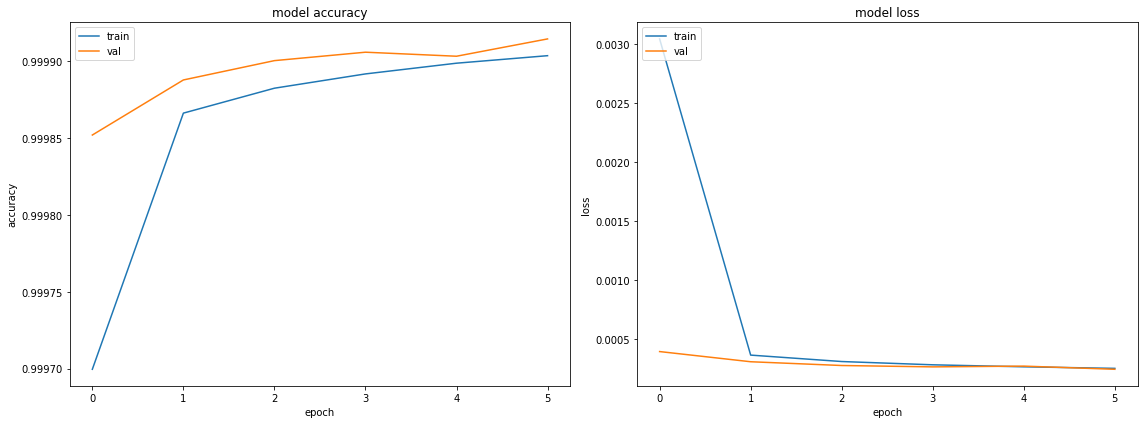

In [18]:
%%time
early_stop= EarlyStopping(monitor='val_loss',patience=3,verbose=0,mode='min',restore_best_weights=False, min_delta=0.0001)

## multi input
if model_config['aux_feats']['use']:
    print("multi input model")
    history = model.fit([train_dict['lstm_feats'], train_aux], train_dict['labels'], verbose=1, epochs=100, batch_size= model_config['batch_size'], \
                    validation_data=([valid_dict['lstm_feats'], valid_aux], valid_dict['labels']), callbacks=[early_stop], shuffle=model_config['shuffle'])
else:
    print("single input model")
    history = model.fit(train_dict['lstm_feats'], train_dict['labels'], verbose=1, epochs=100, batch_size= model_config['batch_size'], \
                        validation_data=(valid_dict['lstm_feats'], valid_dict['labels']), callbacks=[early_stop], shuffle=model_config['shuffle'])

plot_output(history)

In [19]:
print('done')

done


In [65]:
#ls = [len(sent.split(" ")) for sent in sentences_test]

In [66]:
#sentences_test[0]

### Analysis on validation data

In [45]:
# %%time
# #keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/977e2cc7b36040f79dde3d6303d26952/artifacts/models")
# if model_config['aux_feats']['use']:
#     valid_probs = model.predict([valid_dict['lstm_feats'], valid_aux])
# else:
#     valid_probs = model.predict(valid_dict['lstm_feats'])

# valid_probs = valid_probs.reshape(valid_probs.shape[0], valid_probs.shape[1])
# valid_preds = np.where(valid_probs > 0.5, 1, 0)

# valid_true_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(valid_dict['labels'], yvalid)]
# valid_pred_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(valid_preds, yvalid)]
result_valid = evaluate(valid_true_ls, valid_pred_ls)

In [46]:
result_valid

{'count': 85263,
 'count_citations': 41091,
 'mean_acc': 0.9955533613567622,
 'num_mistakes_seq': 3741,
 'num_mistakes_all': 3741,
 'mistakes_per_seq': 1.0,
 'perc_mistakes_seq': 4.387600717779107,
 'mistake_per_citation': 9.104183397824341}

In [25]:
result_valid

{'count': 1758,
 'mean_ser': 0.0021833523167459888,
 'mean_jer': 0.003856683061393975,
 'mean_acc': 0.9998147276365804,
 'num_mistakes_seq': 182,
 'num_mistakes_all': 216}

In [27]:
result_valid

{'count': 1758,
 'mean_ser': 0.0021951766507843297,
 'mean_jer': 0.00484250548228331,
 'mean_acc': 0.999785297054946,
 'num_mistakes_seq': 200,
 'num_mistakes_all': 246}

In [27]:
result_valid

{'count': 1758,
 'mean_ser': 0.002670961444572739,
 'mean_jer': 0.0034327840201287072,
 'mean_acc': 0.9998156923892054,
 'num_mistakes_seq': 191,
 'num_mistakes_all': 247}

In [41]:
#keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/977e2cc7b36040f79dde3d6303d26952/artifacts/models")
count_valid = 0
#valid_df = pd.DataFrame([])
valid_ls = []
for ind in range(len(valid_preds)):
    temp_ls = []
    pred = valid_preds[ind]
    true = valid_dict['labels'][ind]
    if (true == pred).all():
        pass
    else:
        count_valid += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            for x in fp_ind:
                valid_ls.append([ind, 'FP'] + np.array(xvalid[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FP', np.array(xvalid[ind].split(" "))[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            #print(ind, 'False negatives:', fn_ind)
            for x in fn_ind:
                valid_ls.append([ind, 'FN'] + np.array(xvalid[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FN', np.array(xvalid[ind].split(" "))[max(0, x-3):x+4])

In [40]:
valid_mistakes_df = pd.DataFrame(valid_ls, columns=['index', 'error_type', 'x-3', 'x-2', 'x-1', 'x', 'x+1', 'x+2', 'x+3'])

### Analysis of test result

In [47]:
%%time
#keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/1d953e89279b49fdb63cd7b3cb6c8b0b/artifacts/models")
if model_config['aux_feats']['use']:
    test_probs = model.predict([test_dict['lstm_feats'], test_aux])
else:
    test_probs = model.predict(test_dict['lstm_feats'])
test_probs = test_probs.reshape(test_probs.shape[0], test_probs.shape[1])
test_preds = np.where(test_probs > 0.5, 1, 0)

test_true_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(test_dict['labels'], sent_tags_test)]
test_pred_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(test_preds, sent_tags_test)]
result_test = evaluate(test_true_ls, test_pred_ls)

CPU times: user 1min 26s, sys: 5 s, total: 1min 31s
Wall time: 1min 38s


In [48]:
result_test

{'count': 94317,
 'count_citations': 46096,
 'mean_acc': 0.9953616627667279,
 'num_mistakes_seq': 4116,
 'num_mistakes_all': 4116,
 'mistakes_per_seq': 1.0,
 'perc_mistakes_seq': 4.3640064887560035,
 'mistake_per_citation': 8.92919125303714}

In [27]:
result_test

{'count': 1953,
 'mean_ser': 0.001963514243045552,
 'mean_jer': 0.0030484210835085806,
 'mean_acc': 0.9998443850846851,
 'num_mistakes_seq': 169,
 'num_mistakes_all': 204}

In [30]:
tags = {'dataset':'cs_mixed_20k', 'data_split':'test', 'version':2} 
del model_config['embedding']['matrix'] 
opt = model_config['optimizer']
model_config['optimizer'] = str(opt.get_config())
log_mlflow_results(model, result_test, feat_config, model_config, tags)

2020/08/25 10:39:20 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under s3://caps-s3-mlflow/artifacts/4/2fea6f26e6c148318579ed3beaae7f31/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


In [31]:
count_test = 0
test_ls = []
for ind in range(len(test_preds)):
    temp_ls = []
    pred = test_preds[ind]
    true = test_dict['labels'][ind]
    if (true == pred).all():
        pass
    else:
        count_test += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            for x in fp_ind:
                test_ls.append([ind, x, 'FP'] + np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FP', np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            #print(ind, 'False negatives:', fn_ind)
            for x in fn_ind:
                test_ls.append([ind, x, 'FN'] + np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FN', np.array(sentences_test[ind].split(" "))[max(0, x-3):x+4])

In [32]:
test_mistakes_df = pd.DataFrame(test_ls, columns=['seq_index', 'token_index', 'error_type', 'x-3', 'x-2', 'x-1', 'x', 'x+1', 'x+2', 'x+3'])

In [33]:
test_mistakes_df = test_mistakes_df.replace('\n', 'newline')

In [34]:
test_mistakes_df.to_csv('../test_mistakes_custom_new1.csv')

In [24]:
#test_mistakes_df[test_mistakes_df.error_type == 'FP']

### Analysis of eval dataset

In [65]:
%%time
#keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/1d953e89279b49fdb63cd7b3cb6c8b0b/artifacts/models")

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 15.5 µs


In [49]:
if model_config['aux_feats']['use']:
    eval1_probs = model.predict([eval1_dict['lstm_feats'], eval1_aux])
else:
    eval1_probs = model.predict(eval1_dict['lstm_feats'])
eval1_probs = eval1_probs.reshape(eval1_probs.shape[0], eval1_probs.shape[1])
eval1_preds = np.where(eval1_probs > 0.5, 1, 0)


eval1_true_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(eval1_dict['labels'], sent_tags_eval1)]
eval1_pred_ls = [i[0:len(j.split(" "))].tolist() for i,j in zip(eval1_preds, sent_tags_eval1)]
result_eval1 = evaluate(eval1_true_ls, eval1_pred_ls)

In [50]:
result_eval1

{'count': 58229,
 'count_citations': 56850,
 'mean_acc': 0.9997560111589134,
 'num_mistakes_seq': 424,
 'num_mistakes_all': 424,
 'mistakes_per_seq': 1.0,
 'perc_mistakes_seq': 0.7281595081488605,
 'mistake_per_citation': 0.7458223394898856}

In [29]:
result_eval1

{'count': 1328,
 'mean_ser': 4.210459340312366e-05,
 'mean_jer': 0.00069757025053063,
 'mean_acc': 0.9999807715309882,
 'num_mistakes_seq': 27,
 'num_mistakes_all': 36}

### Visualize errors

In [36]:
count_eval1 = 0
eval1_ls = []
for ind in range(len(eval1_preds)):
    temp_ls = []
    pred = eval1_preds[ind]
    true = eval1_dict['labels'][ind]
    if (true == pred).all():
        pass
    else:
        count_eval1 += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            #print(ind, 'fp', fp_ind)
            for x in fp_ind:
                #print(fp_ind)
                eval1_ls.append([ind, x, 'FP'] + np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FP', np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            #print(ind, 'False negatives:', fn_ind)
            #print(ind, 'fn', fn_ind)
            for x in fn_ind:
                eval1_ls.append([ind, x, 'FN'] + np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4].tolist())
                #print(ind, 'FN', np.array(sentences_eval1[ind].split(" "))[max(0, x-3):x+4])

In [37]:
eval_mistakes_df = pd.DataFrame(eval1_ls, columns=['seq_index', 'token_index', 'error_type', 'x-3', 'x-2', 'x-1', 'x', 'x+1', 'x+2', 'x+3'])

In [31]:
#eval_mistakes_df

In [31]:
#sentences_eval1[180]

In [68]:
sentences_eval1[180].split(" ")[1880]

'.'

In [55]:
eval1_dict['lstm_feats'][180][1879]

1290

In [62]:
tokenizer.word_index['.']

4

In [69]:
eval1_dict['spacy_num_feats'][180][1880]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
"IS_ALPHA",  "IS_ASCII", "IS_DIGIT",
            "IS_LOWER",  "IS_UPPER", "IS_TITLE", 
            "IS_PUNCT",  "IS_SPACE", "IS_STOP", 
            "LIKE_NUM",  "LIKE_URL", "LIKE_EMAIL", #"LENGTH",
        ]

In [71]:
eval1_parscit_arr[180][1879]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [39]:
eval_mistakes_df.to_csv('../eval_mistakes_custom_new1.csv', index=False)

### Save eval results to file

In [41]:
ind = 0
eval_path_dict = {}
for fpath in os.listdir(eval_without_intra_newline_path):
    if fpath not in ['data-gen-config.json', 'data_generation_stats.csv'] and ".csv" in fpath:
        eval_path_dict[ind] = fpath
        ind += 1

In [71]:
eval_folder_path = '/nlp/eval_data_retok_predictions_f3a9cc61e30f460499b95a4c2b7957ae'
if not os.path.exists(eval_folder_path):
    os.makedirs(eval_folder_path)
for ind in range(len(eval_preds1)):
    #print(ind)
    df = pd.DataFrame([], columns=['x', 'y'])
    seq_len = min(len(sentences_eval1[ind].split(" ")), maxlen)
    df['x'] = sentences_eval1[ind].split(" ")[0:seq_len]
    df['y'] = eval_preds1[ind][0:seq_len]
    df.to_csv(os.path.join(eval_folder_path, eval_path_dict[ind][0:-4] + '_pred.csv'))

### Log Eval results to MLFlow

In [32]:
tags = {'dataset':'cs_mixed_20k', 'data_split':'eval_with_intra_newline_path','version':2}
#del model_config['embedding']['matrix'] 
#opt = model_config['optimizer']
#model_config['optimizer'] = str(opt.get_config())
log_mlflow_results(model, result_eval1, feat_config, model_config, tags)

2020/08/25 10:39:39 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under s3://caps-s3-mlflow/artifacts/4/285116d6837b42899453eaf903446efb/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


### Saving features to file

In [59]:
# %%time
# np.save('/nlp/temp/train_dict_labels.npy', train_dict['labels'])
# np.save('/nlp/temp/train_dict_lstm_feats.npy', train_dict['lstm_feats'])
# np.save('/nlp/temp/train_dict_spacy_feats.npy', train_dict['spacy_num_feats'])

# np.save('/nlp/temp/valid_dict_labels.npy', valid_dict['labels'])
# np.save('/nlp/temp/valid_dict_lstm_feats.npy', valid_dict['lstm_feats'])
# np.save('/nlp/temp/valid_dict_spacy_feats.npy', valid_dict['spacy_num_feats'])

# np.save('/nlp/temp/test_dict_labels.npy', test_dict['labels'])
# np.save('/nlp/temp/test_dict_lstm_feats.npy', test_dict['lstm_feats'])
# np.save('/nlp/temp/test_dict_spacy_feats.npy', test_dict['spacy_num_feats'])

In [1]:
# np.save('/nlp/temp/eval1_dict_labels.npy', eval1_dict['labels'])
# np.save('/nlp/temp/eval1_dict_lstm_feats.npy', eval1_dict['lstm_feats'])
# np.save('/nlp/temp/eval1_dict_spacy_feats.npy', eval1_dict['spacy_num_feats'])

In [9]:
import re

In [10]:
sentences_eval1[0]

'1 . Egbor M , Ansari T , Morris N , Green CJ , Sibbons PD . Morphometric placental villous and vascular abnormalities in early- and late - onset pre - eclampsia with and without fetal growth restriction . BJOG . 2006;113:580 - 9 . \n 2 . Macara L , Kingdom JC , Kaufmann P , Kohnen G , Hair J , More IA , Lyall F , Greer IA . Structural analysis of placental terminal villi from growth - restricted pregnancies with abnormal umbilical artery Doppler waveforms . Placenta . 1996;17:37 - 48 . \n 3 . Salafia CM , Ernst LM , Pezzullo JC , Wolf EJ , Rosenkrantz TS , Vintzileos AM . The very low birthweight infant : maternal complications leading to preterm birth , placental lesions , and intrauterine growth . Am J Perinatol . 1995;12:106 - 10 . \n 4 . Salgado SS , Salgado MKR . Structural changes in pre - eclamptic and eclamptic placentas - an ultrastructural study . J Coll Physicians Surg Pak . 2011;21:482 - 6 . \n 5 . Higgins M , Felle P , Mooney EE , Bannigan J , McAuliffe FM . Stereology of

In [11]:
bla = re.search('\n [0-9]+ .', sentences_eval1[0]).start()

In [13]:
bla

231

In [100]:
for ind in range(100):
    print(np.array(xtrain[ind].split(" "))[np.where(np.array(ytrain[ind].split(" ")) == 'B-CIT')])

['1' '2' '3' '4' '5' '6' '7' '8)' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27']
['Johnson' 'Johnson' 'Krause' 'Meinzer' 'Nepal' 'Pfannschmidt' 'Pfennig'
 'Potatoes' 'Rushton' 'Schulze' 'Schulze' 'Šimůnek' 'Ahmadalipour']
['NVIDIA' 'OpenCV' 'Relating' 'Softmax' 'Stochastic' 'FLIR' 'VGG16' 'Y.'
 'Chapman' 'Eckblad' 'Bakker' 'Franco' 'Eawag' 'Commission']
['(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '('
 '(' '(' '(' '(' '(' '(' '(' '(']
["d'Ambrosio" 'Catania' 'Smith' 'Valério' 'Arsie' 'Aitken' 'Elhai' 'Elhai'
 'Khoury' 'Kim' 'Kwon' 'Müller' 'Tokunaga' 'Ad' 'D.' 'P.' 'GBA' 'Hacker'
 'Koeck' 'Kohl' 'D.' 'Markart' 'Markart' 'Mazzilli' 'R.' 'Y.' 'J.' 'Z.'
 'J.' 'H.' 'H.' 'J.' 'Y.' 'Y.' 'Z.' 'H.' 'H.' 'H.' 'W.' 'W.' 'S.' 'K.'
 'K.' 'C.' 'X.' 'G.' 'Z.' 'H.' 'Y.' 'X.' 'J.' 'Y.' 'H.' 'Y.' 'K.' 'H.'
 'D.' 'A.' 'J.' 'J.' 'L.' 'D.' 'H.']
['(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '(' '('
 '(' '(' '(' '('

In [149]:
for ind in range(100):
    print(ind, '----->', sentences_train[ind][0:500])

0 -----> 1 ) J. Chang et al . , “ 12.1 A 7 nm 256Mb SRAM in high - k metal - gate FinFET technology with write - assist circuitry for low - VMIN applications , ” 2017 IEEE International Solid - State Circuits Conference ( ISSCC ) , San Francisco , CA , 2017 , pp . 206 - 207 . 
 2 ) T. Standaert et al . , “ BEOL process integration for the 7 nm technology node , ” 2016 IEEE International Interconnect Technology Conference / Advanced Metallization Conference ( IITC / AMC ) , San Jose , CA , 2016 , pp . 2 -
1 -----> Griffiths , M. D. ( 2013 ) . Social networking addiction : Emerging 
 themes and issues . Addiction : Research & Therapy , 4 , 4–5 
 . http://doi.org/10.4172/2155-6105.1000e118 
 Griffiths , M. D. , Kuss , D. J. , & Demetrovics , Z. ( 2014 ) . Social networking addiction : An overview of preliminary findings . In K. P. 
 Rosenberg & L. Curtiss Feder ( Eds . ) , Behavioral Addictions : Criteria , Evidence , and Treatment ( pp . 119–141 ) . San Diego , CA : US 
 : Elsevier Acade

In [143]:
np.where(np.array(sent_tags_train[0].split(" ")) == "B-CIT")

(array([  0,  62, 112, 117, 121, 154, 182, 238, 326, 373, 404, 492, 540,
        609, 639, 664, 706, 751, 835, 865, 897, 939, 969, 995]),)

In [6]:
# string = sentences_eval1[0]
# pattern = '\n [a-zA-Z0-9]+ .'

In [7]:
#re.findall(pattern, sentences_eval1[2])

In [152]:
# for ind in range(1000):
#     bind = np.where(np.array(sent_tags_eval1[ind].split(" ")) == 'B-CIT')
#     for b in bind[0][0:3]:
#         print(b)
#         print(sentences_eval1[ind].split(" ")[max(0, b-2): b+3])

In [153]:
for ind in range(1000):
    bind = np.where(np.array(ytrain[ind].split(" ")) == 'B-CIT')
    for b in bind[0][0:3]:
        print(b)
        print(xtrain[ind].split(" ")[max(0, b-4): b+5])

0
['1', ')', 'Xu', ',', 'S.']
37
['-', '1115', '.', '\n', '2', ')', 'For', 'reviews', 'on']
51
[',', 'see', ':', '\n', '3', ')', 'For', 'reviews', 'on']
0
['Johnson', ',', 'A.I.', ',', '1967']
25
['\n', 'Office', '.', '\n', 'Johnson', ',', 'M.R.', ',', 'Anhauesser']
54
['\n', 'Africa', '.', '\n', 'Krause', ',', 'P.', ',', '2001']
0
['NVIDIA', 'GeForce', 'GTX', '1070', '.']
20
[')', '\n', '.', '\n', 'OpenCV', 'Library', '.', 'Available', 'online']
38
[')', '\n', '.', '\n', 'Relating', 'ROC', 'and', 'CMC', 'curves']
0
['(', '1', ')', 'European', 'Centre']
34
[')', '.', '\n', '\n', '(', '2', ')', 'Tiwari', 'TSP']
92
['-', '0', '.', '\n', '(', '3', ')', 'WHO', 'Expanded']
0
["d'Ambrosio", 'S', ',', 'Misul', 'D']
48
[',', '2005', '.', '\n', 'Catania', 'A', 'E', ',', 'Misul']
120
['Mechanical', 'Engineers', '.', '\n', 'Smith', 'GP', ',', 'Golden', 'DM']
0
['(', '\n', '1', ')', 'Ansys']
14
['\n', 'Guide', '.', '\n', '(', '2', ')', 'Lupant', 'D.']
48
[',', '2011', '.', '\n', '(', '3', ')', 'Sa

In [140]:
ind = 6
np.where(train_custom_arr[ind].reshape(1,-1)[0] == 1)

(array([  0, 249]),)

In [141]:
np.where(np.array(ytrain[ind].split(" ")) == 'B-CIT')

(array([  0,  44,  88, 118, 167, 181, 204, 303, 329, 350, 390]),)

In [142]:
xtrain[ind]

'Senécal , C. , Lavoie , K. , & Koestner , R. ( 1997 ) . Trait and situational \n factors in procrastination : An interactional model . Journal of Social Behavior and Personality , 12 , 889–903 . \n Retrieved from https://www.researchgate.net/publication/279691436_Trait_and_Situational_Factors_in_Procrastination_An_Interactional_Model \n Young , B. ( 2006 ) . A study on the effect of internet use and social capital on \n the academic performance . Development & Society , 35(1 ) , 107–123 . Retrieved from Retrieved from http://s - \n space.snu.ac.kr / bitstream/10371/86685/1/6.%20A%20STUDY%20ON%20THE%20EFFECT%20OF%20INTERNET%20USE%20AND%20SOCIAL%20CAPITAL%20ON%20THE%20ACADEMIC%20PERFORMANCE%20]BaeYoung.pdf \n O. Bretschger , E. Marsili , P. Atanassov , A.J. Schuler , Influence \n of anode surface chemistry on microbial fuel cell operation , ( 2015 ) \n . \n O. Mehra , M. Jackson , Iron oxide removal from soils and clays by a dithionite – citrate system buffered with \n sodium bicarbonat

In [1]:
import pandas as pd

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
test_df = pd.read_csv('../test_mistakes_windownew.csv')

In [4]:
eval_df = pd.read_csv('../eval_mistakes_windownew.csv')

In [6]:
eval_df

,seq_index,token_index,error_type,x-3,x-2,x-1,x,x+1,x+2,x+3
0,171,420,FP,",",Ekpa,newline,",",Cooper,TK,","
1,210,772,FN,),.,newline,18,Hunger,-,Craig
2,371,1286,FN,34,.,newline,.,A,Consensus,on
3,412,251,FN,76,.,newline,[,8]M.,Preene,","
4,412,561,FN,4260,.,newline,[,17]V.Hamm,",",B.B.Sabet
5,706,828,FN,after,subacute,newline,Monica,",",F.Z.,","
6,712,2833,FN,346−352,.,newline,66,.,http://www.ozm.cz/en/sensitivity-tests/small-s...,newline
7,776,282,FN,257,.,newline,[,10]J.W.Xi,",",Control
8,776,416,FN,129,.,newline,[,14]X.X.Zhao,",",L.J.Li
9,841,1458,FN,remodeling,in,newline,Saccharomyces,cerevisiae,mutants,affected
